# I. Data Processing
## A. Assumptions and Imputation
As disclaimed by the original problem prompt, the initial dataset provided for this challenge was messy; numerous entries stored omitted (`NaN`) values for certain features (e.g. `number_of_interviews`), multiple features had a near-perfect correlation to the target column due to post-trial intuition (e.g. `program_duration_days`), and some features proved to be extraneous in nature (e.g. `id`). Combating these shortfalls of the data necessitated a program that would be capable of first handling the missing values and second dropping columns that were either highly biased or extraneous. To accomplish this, the simple program below was scripted.


In [9]:
import pandas as pd

# Filters data to return an initial set for analysis
def filter_data(df):
	# Initializes array of indices to drop from dataframe
	indicesToDrop = []
	# Iterates through rows, recording row index if the respective user's status is marked 'Active'
	for entry in df.iterrows():
		if entry[1][1] == "Active":
			indicesToDrop.append(entry[0])
	# Drops recorded indices using boolean mask (significantly reduces runtime)
	df = df[~df.index.isin(indicesToDrop)]
	# Explicitly drops any remaining, extraneous columns; selection criteria explained below
	df.drop(labels=['id', 'program_duration_days', 'pathrise_status'], axis=1, inplace=True)
	return df

As commented throughout the script, the method first sought to drop entries whose status column was marked `Active`, since current fellows actively engaged in their current job search would skew the prediction model to assume more fellows failed to place than do in reality. The most straightforward approach to dropping such entries would be to linearly iterate through their enclosing list and drop each row marked `Active`. However, this program instead recorded all such indices of active entries and employed a boolean mask to accomplish the dropping procedure in a third of the time, while still maintaining a time complexity of $O(n)$ for the operation.

Moving forward, the method then dropped features that were either considered to be extraneous or displayed near-perfect correlation to the target variable (these features were deemed to be `id`, `program_duration_days`, `pathrise_status`). A truncated representation of the filtered dataset is shown below.

| primary_track | cohort_tag | placed | employment_status | highest_level_of_education | length_of_job_search | biggest_challenge | professional_xp | work_auth_status | interviews | applications | gender | race |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| SWE | AUG19A | 1 | Unemployed | Bachelor's Degree | 1-2 months | Hearing back on my applications | 1-2 years | F1 Visa/OPT | 10.0 | 100 | Male | East Asian or Asian American |
| SWE | AUG19A | 0 | Employed Part-Time | Bachelor's Degree | Less than one month | Getting past final round interviews | 1-2 years | Citizen | 4.0 | 15 | Female | Latino or Hispanic American |
| Data | AUG19C | 0 | Unemployed | Master's degree | 3-5 months | Lack of relevant experience | 5+ years | Citizen | 5.0 | 50 | Male | Decline to Self Identify|

The `id` of the entry proved to be unnecessary, as order would not influence the training of the model. The decision to then drop the columns for the user’s days in the program as well as the user’s current status was carried out after computing the prediction precision of these two columns to be at or near 100% (95% for program days; 100% for status) for the target column when trained using a boosted tree model (justification for this model will be included on a later page). Since values for both these columns may only be collected when or after the target value (whether the user placed or not) is collected, they were dropped from the dataframe. 


# II. Univariate Correlations
## A. Boosted Decision Tree Model
After processing the initial dataset, the first logical step in drawing insights from its data involved calculating the precision of each individual feature in predicting the target value, a binary unit variable treated as a boolean in this model. Such a set of computations would enable our data team to glean insight into which components individually influenced the outcome the most.

The decision to employ a boosted decision tree model as opposed to more widely-used classification models (e.g. logistic regression, SVM, etc.) was invoked under the observation that the processed dataset displayed both high variance and high bias in its values. Indeed, in an effort to combat the effects of these shortfalls, boosting the supervised learning algorithm of a standard decision tree appeared both judicious and implementable. A simplified diagram of the boosted decision tree model and an enumeration of the particular instantiation parameters applied to the model implemented in this study are expounded in Appendix A1 and A2.

## B. Visualization of Output
A table of the precision and recall statistics for the boosted tree models trained on each individual feature is shown below.

|  | Precision | Recall |
| --- | --- | --- |
| primary_track | 0.59 | 0.58 |
| cohort_tag | 0.55 | 0.56 |
| employment_status | 0.53 | 0.52 |
| level_of_education | 0.56 | 0.51 |
| length_of_search | 0.53 | 0.51 |
| biggest_challenge | 0.55 | 0.52 |
| professional_experience | 0.52 | 0.51 |
| work_auth_status | 0.54 | 0.52 |
| num_interviews | 0.53 | 0.52 |
| num_applications | 0.56 | 0.55 |
| gender | 0.59 | 0.57 |
| race | 0.55 | 0.53 |

## C. Interpretation and Analysis
After training the models and computing their precision and recall statistics for predicting the value of the target column, the user’s ultimate placement, the feature with the highest precision proved to be the user’s primary track of choice, followed closely by the user’s gender. As shown above, both of these univariate models displayed a precision of around `0.6` with respect to the target variable. Notably, though, both of these features also displayed a lower variance than most other columns. Bar charts reflecting this bias are shown below.


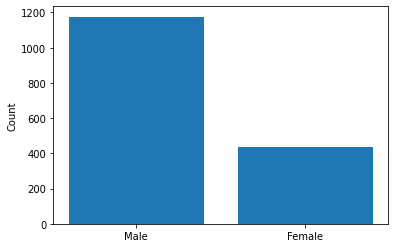

In [24]:
# Generates bar chart to highlight the lower-than-average variance of the "gender" column
def bar_chart(df):
	# Initializes male and female counters
	male = 0
	female = 0
	# Iterates through list of rows in the gender column, counting males and females
	for entry in df.iloc[:]['gender']:
		if entry == 'Male':
			male += 1
		elif entry == 'Female':
			female +=1
	# Uses the matplotlib library to plot bar charts that display the rift in gender frequencies
	plt.bar(x=['Male', 'Female'], height=[male, female])
	plt.ylabel('Count')
	plt.show()

sampleSet = pd.read_csv("new_pathrise_data.csv")
bar_chart(sampleSet)

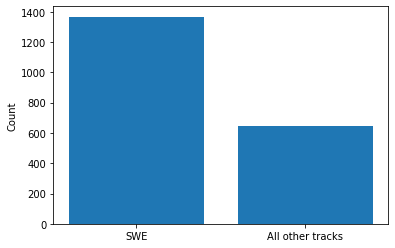

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Mirrors code above, but instead plots the rift between fellows interested in SWE as opposed to all other tracks
def bar_chart(df):
	swe = 0
	allElse = 0
	for entry in df.iloc[:]['primary_track']:
		if entry == 'SWE':
			swe += 1
		else:
			allElse +=1
	plt.bar(x=['SWE', 'All other tracks'], height=[swe, allElse])
	plt.ylabel('Count')
	plt.show()

sampleSet = pd.read_csv("new_pathrise_data.csv")
bar_chart(sampleSet)

For this reason, it would be injudicious to suggest that these features should solely be used as indicators for the target variable, since both displayed a redundant value (`Male` for the user’s gender; `SWE` for the user’s primary track of choice), lowering variance to a point of unreliability. It was necessary, then, to begin training models with variations of the features provided in order to craft a model that was both precise and reliable in its predictions.


# III. Multivariate Correlations
## A. Iterative Model of Combinations
The initial challenge in computing the prediction precision of each possible set of features in order to find the optimal model was iterating through all listed features to generate a list of all possible combinations between such columns. Ultimately, the program below was used to accomplish this task.


In [6]:
# Finds all possible unordered combinations between the set of all columns
def find_all_combinations(df):
	# Initializes a list of all columns in the dataframe and an empty list to store the combinations
	setColumns = [col for col in df]
	emptySet = []
	# Iterates through each column in the set of columns to find combinations and store in the empty list
	for column in range(0, len(setColumns)):
		currentThread = [str(column)]
		# Stores original column as an entry in the empty list; stored as a tuple for added security via immutability
		emptySet.append(tuple(currentThread))
		# Iterates through remaining columns in the set to find combinations stemming from original column
		for otherColumn in range(column+1, len(setColumns)):
			if column == len(setColumns)-1: break
			else: 
				currentThread = [str(column)]
				currentThread.append(str(otherColumn))
				emptySet.append(tuple(currentThread))
				# Iterates through final remaining columns to cover all combinations
				for remainingCol in range(otherColumn+1, len(setColumns)):
					currentThread.append(str(remainingCol))
					emptySet.append(tuple(currentThread))
	return emptySet

As expounded in the program’s comments, tuples were employed to store each possible combination of feature columns in an effort to bolster security and immutability of the output. Additionally, as shown above, the program displayed a worst-case time complexity of $O(n^{3})$, where n represents the number of features to find combinations between. With this growth function, it was computed that the program would be capable of finding all existing combinations of any set $n ≤ 10^{4}$ on any machine with a clock speed of at least 3.5 GHz. Since there were only 13 feature columns in the filtered dataset, it was calculated that this function would be both capable and scalable in completing this operation.
## B. Optimization and Results
After collecting all possible combinations of the 13 feature columns (totaling 377, all of which are included in Appendix B1), the flagship challenge of this analysis proved to be the optimization of weights for each individual combination of independent variables. To accomplish this, the aforementioned boosted tree models were structured and trained in both Create ML and TensorFlow for cross-platform verification of results. Below is a table of the leading 3 combinations from these trials, each ranked by precision and recall.


|  | Precision | Recall |
| --- | --- | --- |
| All features | 0.78 | 0.77 |
| All features except gender and race | 0.73 | 0.72 |
| Primary track, # interviews, and # applications | 0.70 | 0.70 |

## C. Interpretation and Analysis
Through exhausting and instantiating each possible combination of feature columns for the model, the most and least valuable combinations of variables could be delineated with a simple `.head()` invocation of the sorted array.

Indeed, as shown above, the combination that displayed the highest precision while maintaining a high recall was ironically that which included all 13 feature columns in its structure. With a supervised implementation of the boosted tree model on these combinations and an optimization of the model’s weights for each individual column, the model achieved a precision of `0.78` and a recall of `0.77`, promising metrics that outstrip the `0.7` boundary that is typically cited and referred to by machine learning engineers and data scientists.


# V. Limitations and Recommendations
## A. Conclusions and Limitations
From the results of the study expounded above, it becomes notable that the most precise and reliable model for predicting whether or not a fellow will place involves manipulation of all features included in the filtered dataset, with the `gender`, `employment_status`, and `preferred_track` columns in particular holding a greater weight than would have likely been expected. Indeed, even when the dataset was filtered once more to solely include fellows who had placed, this same boosted tree model was able to display a precision of `0.71` and recall of `0.70` in predicting the number of days it would take for a given fellow to place, provided the original binary prediction was positive. The versatility of the boosted tree model in providing robust results for both tabular classification and regression problems can further be seen through these high-precision results across both models.

As would be true for any study, however, it is worthwhile to acknowledge the limitations of this computational approach so as to fuel enhancement of its reliability and understanding by the greater academic community. For this reason, there are two flagship limitations researchers and engineers should account for when implementing the findings of this work: the potential for under and overfitting by the model and the lack of hyperparameter optimization in the approach due to limited computational power.

First, though the results of this model prove to be respectably precise while maintaining limited bias, it is possible in any machine learning problem that a smaller dataset is more prone to under or overfitting by the model. In the context of this challenge, the dataset held an initial `2,544` rows. Upon filtering and clustering of the data, this count was reduced to `2,012`. Given that this is a relatively small dataset for a machine to train its predictions on, it is worth acknowledging that this model’s precision and reliability may diminish in accordance with the scaling of its validation dataset.

Second, it is further worth noting that there exists potential that the model outlined and generated through this notebook is, in fact, not the most optimal solution to this problem. Though the model of choice was tested and verified to fit this problem more aptly than any other with regard to both its proven accuracy and empirical implementability, the parameters defined by the model were left unaltered from those considered to be standard in industry (see Appendix A2). The reason for this decision was primarily driven by limited computational power. Indeed, there exists an infinite number of combinations of parameters for generating such a model, and while an epsilon-incremented bisection search algorithm would likely be able to optimize parameters within a defined margin of error in reasonable time, such a logarithmic algorithm was computed to consume an estimated 15 hours to complete on a machine with a clock speed of 3.5 GHz. The confirmation proof for this mathematical limitation is shown below.

\begin{equation}
\prod_{i=1}^{7} \frac{max_{i}}{ε_{i}}
= n
\end{equation}

Assuming an epsilon of 1 for `max. iterations` and `max. depth` and an epsilon of 0.1 for `min. loss reduction`, `min. child weight`, `row subsample ratio`, `column subsample ratio`, and `step size` of the model, we can write that

\begin{equation}
\prod_{i=1}^{7} \frac{max_{i}}{ε_{i}}
= n
\\
= \frac{max_{1}}{ε_{1}} × \frac{max_{2}}{ε_{2}} × ... × \frac{max_{7}}{ε_{7}}
\\
= \frac{10}{1} × \frac{10}{1} × ... × \frac{1}{0.1}
\\
= 10 × 10 × 10 × 10 × 10 × 10 × 10 = 10,000,000 = n.
\end{equation}

Thus, with the clock speed of an average laptop, iteration through all 10,000,000 permutations of the model parameters would be far too costly for an expectedly marginal return in model precision.

For this reason, the parameters chosen to define the boosted tree model of this paper are likely not optimal. Of course, though, while it is worthwhile for future studies to aim to optimize these parameters, it is also widely established that an engineer’s choice of learning model far outstrips the particular parameters chosen for that model when examining accuracy and reliability, suggesting that dismissal of this limitation would not largely affect the outcome of the work.

## B. Interpretations and Recommendations

Multiple insights may be drawn from the results of this work. Of these, though, two appear more valuable than the rest with regard to their applicability in the optimization of company operations: the importance of demographic alignment with industry demand and the relation between one’s degree of professional development and their aptness for the program.

First, there exists a notable correlation between the natural demand for certain demographics within the technology sector and a given applicant’s chance of placement. One of the most exceptional metrics in the model that highlights this relation was the primary track of choice by the applicant. For certain tracks like `PSO` or `Design`, a significantly lower percentage of applicants ultimately placed than did in most other tracks. Indeed, only `0.333` (33.3%) of fellows pursuing a career in PSO ultimately placed, while `0.508` (50.8%) of those pursing SWE in the filtered dataset ultimately placed.

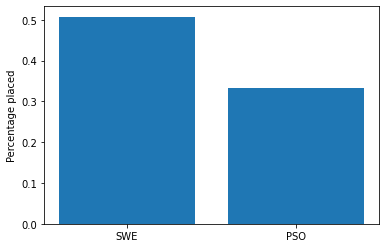

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Generates bar charts displaying the placement percentages of fellows pursuing SWE and PSO primary tracks
def track_charts(df):
    # Initializes placement counters for both successes and failures; also initializes row counter
	swePlaced = 0; psoPlaced = 0
	sweNotPlaced = 0; psoNotPlaced = 0
	row = 0
    # Iterates through dataframe to count placements for fellows who selected to pursue either SWE or PSO
	for entry in df.iloc[:]['primary_track']:
		if entry == 'SWE':
			if df.iloc[row][6] == 1:
				swePlaced += 1
			else:
				sweNotPlaced += 1
		if entry == 'PSO':
			if df.iloc[row][6] == 1:
				psoPlaced += 1
			else:
				psoNotPlaced += 1
        # Increments row for iteration
		row += 1
    # Uses matplotlib library to plot the bar charts
	plt.bar(x=['SWE', 'PSO'], height=[swePlaced/(swePlaced+sweNotPlaced), psoPlaced/(psoPlaced+psoNotPlaced)])
	plt.ylabel('Percentage placed')
	plt.show()

sampleSet = pd.read_csv("new_pathrise_data.csv")
track_charts(sampleSet)

A chi-squared test, then, would suggest that we can state with over 95% certainty that the chosen track of the applicant significantly affects his or her chance at placement. Furthermore, additional demographic data including the applicant’s `work_authorization_status` and `employment_status` empirically affected the fellow’s probability of placing (38.6% for contractors as opposed to 51.7% for part-time engineers). For these reasons, it is reasonable to suggest that a significant consideration in forecasting whether a fellow will place or not is the extent to which his or her inherent demographics align with the current demand for such individuals from within the technology sector.

Second, it is worth noting that the degree of professional development of an applicant also held higher-than-average weight in the boosted model, indicating its relative significance in determining whether an applicant would place or not. From the pool of fellows who marked their `biggest_challenge_in_job_search` to be `Figuring out which jobs to apply to`, for example, only 43.7% ultimately placed, as opposed to 52.3% for those selecting `Getting past final round interviews` as their biggest challenge. This disparity in placement probability, then, follows a disparity in relative experience, as applicants who have succeeded in reaching the final round interviews likely only seek fine-tuning in their application process, while fellows who are unsure of which position to begin with are bound to be much more amateur.

It is also worth expounding that this metric has been selected to highlight this rift as opposed to more direct columns such as `work_experience` or `highest_level_of_education` because success in the application process is assumed to be much more convoluted than to be directly correlated to definitive metrics such as these. It appears as though the ability to successfully make it to final interview rounds, then, accounts for more confounding variables than would a degree. Further bolstering this finding is the observation that the ratio of interviews to applications is a valuable metric in predicting applicant success as well. Indeed, for applicants having more than `0.01` (1%) of their applications lead to interviews, there exists a placement rate of around `0.461` (46.1%). For applicants having more than `0.30` (30%) of their applications lead to interviews, however, this figure rises to `0.536` (53.6%), indicating already-existent success in the interview process as a favorable quality for potential fellows in our program.

From these two interpretations of the model follow two distinct recommendations for the executives of the company: first, to invest more capital in general market research of the current demands and future projections of all flagship technology sectors; and second, to encourage recruiters and screening interns to target applicants who are struggling solely in the end stages of the interview and application process. Indeed, larger investments into the current demands of major technology sectors (viz. data science, design, software engineering, and PSO) will allow our program’s recruiters and admissions interns to better understand the inherent qualities and characteristics that the most prominent technology companies are seeking in today’s applicants. Having this database of robust and reliably-gleaned data would invariably bolster our ability to select the applicants most apt to excel in the contemporary employment atmosphere within the technology industry as a whole.

Furthermore, encouraging our program recruiters to target applicants who are floundering only in the final stages of their application process will enable our team advisors to frictionlessly channel their expertise into truly connecting with fellows to work toward fine-tuning their professional skillset and interview strategy so as to express their talents in the most attractive manner possible. This will recoup opportunity cost due to a shorter mean time spent with each individual applicant while simultaneously filtering applicants with no particular conception as to whether or not they even want to pursue a career in technology, a notably more challenging case for our advisors to navigate.

Implementing such changes into company operations would be to follow the advice of the data provided by the applicants themselves; to work with consumer desires rather than organizational interests will be to reinforce the decentralized nature of Pathrise and its mission, and with luck this work may provide valuable insight into forwarding that mission into the future.
# Appendix A
## I. Basic Boosted Tree Diagram
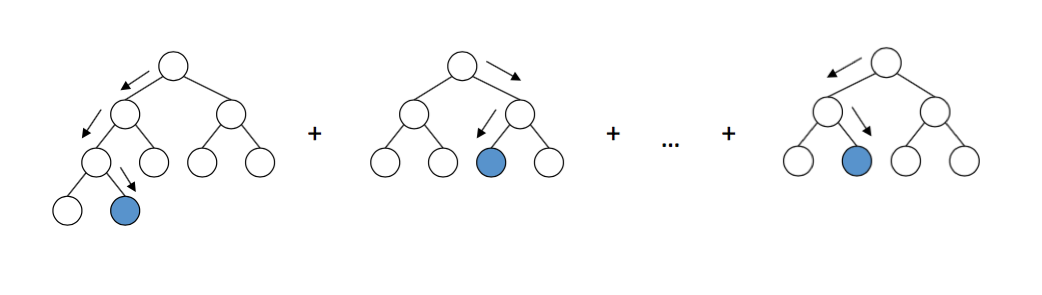

(Fetched from https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html).

## II. Parameters for the Model

|  |  |
| --- | --- |
| Max. iterations | 0.77 |
| Max. depth | 0.73 |
| Min. loss reduction | 0.70 |
| Min. child weight | 0.1 |
| Row subsample ratio | 1 |
| Column subsample ratio | 1 |
| Step size | 0.3 |

# Appendix B
## I. All Combinations of 13 Features
In the context of this challenge, each of the numbers 0 through 12 represented a single, distinct feature column.